# Camera Calibrations

In [62]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

# Video of a chessboard 
CALIBRATION_VIDEO = '/home/andretelfer/shared/curated/fran/v1/camera-calibration/calib1.mp4'

# Example experiment video/dlc labels
EXAMPLE_EXPERIMENT_VIDEO = '/home/andretelfer/shared/curated/fran/v1/videos/resized_960x540_30fps/m1.mp4'
EXAMPLE_EXPERIMENT_MOUSE_LABELS = '/home/andretelfer/shared/curated/fran/v1/videos/resized_960x540_30fps/mouse_labels/m1DLC_resnet50_agrpNov19shuffle1_400000.h5'
EXAMPLE_EXPERIMENT_LANDMARK_LABELS = '/home/andretelfer/shared/curated/fran/v1/videos/resized_960x540_30fps/landmark_labels/m1DLC_resnet50_agrp_landmarksNov17shuffle1_50000.h5'

## Camera Calibrations

Useful reference: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

### What does the calibration video look like?
Just a video of a chessboard, moving either the camera or board around

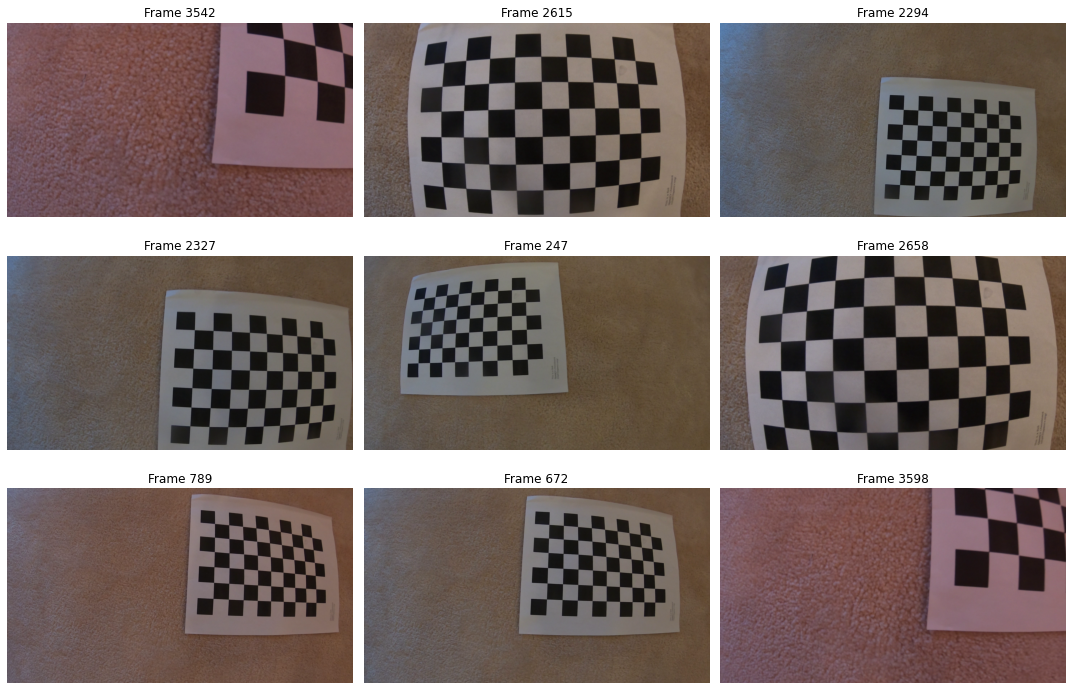

In [2]:
def get_frame(cap, idx):
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame

rows = 3
cols = 3

distortion_cap = cv2.VideoCapture(CALIBRATION_VIDEO)
frame_count = int(distortion_cap.get(cv2.CAP_PROP_FRAME_COUNT))
sample_frames = np.random.choice(np.arange(frame_count), size=rows*cols)

plt.figure(figsize=(15, 10))
gs = plt.GridSpec(rows, cols)
for plt_idx, frame in enumerate(sample_frames):
    plt.subplot(gs[plt_idx])
    plt.imshow(get_frame(distortion_cap, frame))
    plt.title(f"Frame {frame}")
    plt.axis('off')
    
plt.tight_layout()

### Finding the points on the chessboard

In [42]:
# Which frames to sample
SAMPLE_FRAMES = [*np.arange(2400, 3100, 50), *np.arange(0, 2000, 50)]

# This seems to only work when its the number of squares on each side -1 
CHESSBOARD_SIZE = (6,9)

# Use this if the experiment videos are in a different resolution than the calibration videos.
# this should be the width x height of the experimental video
RESIZE_RESOLUTION = (960, 540)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((1, CHESSBOARD_SIZE[0]*CHESSBOARD_SIZE[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for frame_idx in SAMPLE_FRAMES:
    frame = get_frame(distortion_cap, frame_idx)
    
    if frame is None:
        continue 
        
    frame = cv2.resize(frame, RESIZE_RESOLUTION)
    gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
        
    # If found, add object points, image points (after refining them)
    if ret == True:
        print(f"Found points in frame")
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, CHESSBOARD_SIZE, (-1,-1), criteria)
        imgpoints.append(corners2)
    else:
        print("Could not find points in frame")

Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Could not find points in frame
Could not find points in frame
Could not find points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Found points in frame
Could not find points in frame
Could not find points in frame
Could not find points in frame
Could not find points in frame
Could not fin

## Model Distortion
If the error printed below is large (in the hundreds) the model isn't fitting well, may need to change things

In [43]:
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_CHECK_COND + cv2.fisheye.CALIB_FIX_SKEW

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

img = get_frame(distortion_cap, 200)
h,w = img.shape[:2]

tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error
    
tot_error

1.6916570704566674

## Distortion Parameters
https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

Camera Matrix and Distortion Coefficients. These can be saved so above code does not need to be run again
- the original frame size also matters

In [44]:
mtx

array([[545.61892848,   0.        , 485.25672838],
       [  0.        , 551.41129002, 265.09366482],
       [  0.        ,   0.        ,   1.        ]])

In [45]:
dist

array([[-0.34117817,  0.17589757,  0.00307519, -0.00043717, -0.05181584]])

In [46]:
frame.shape

(540, 960, 3)

## Removing Distortion from Images
The previous step found two sets of parameters used to model distortion

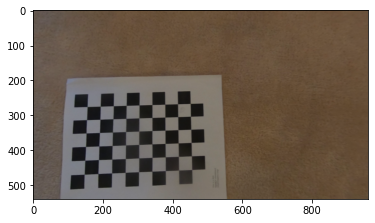

In [47]:
dst = cv2.undistort(frame, mtx, dist)
plt.imshow(dst)

## Cleaning up images

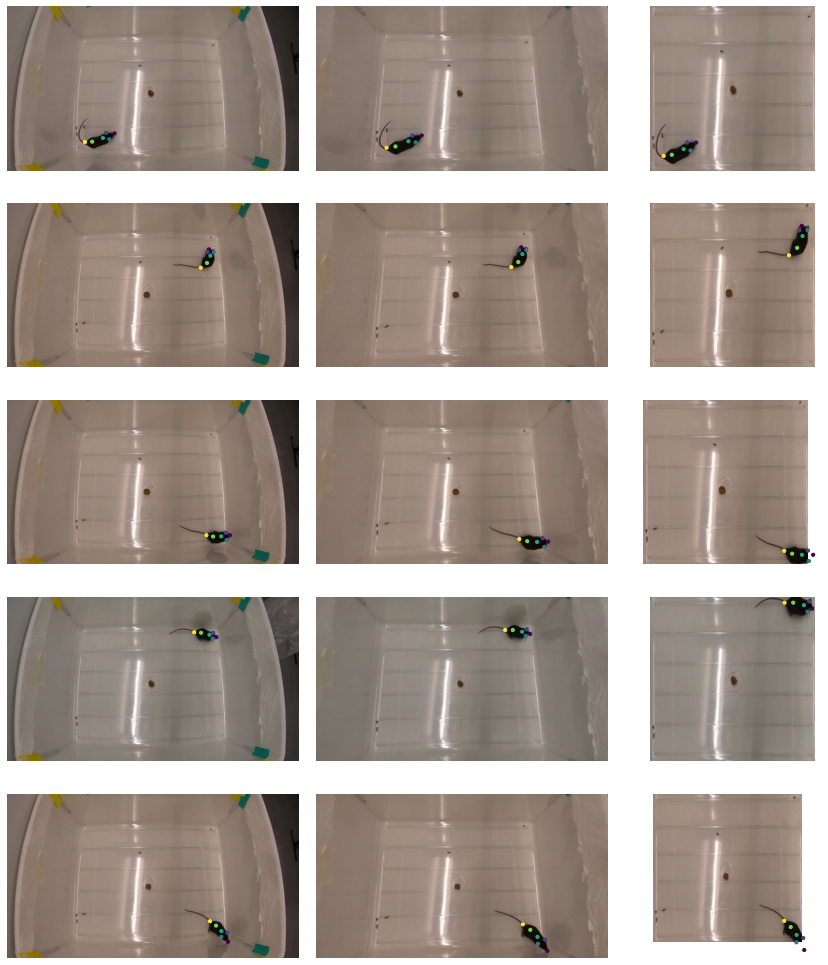

In [84]:
rows = 5

gs = plt.GridSpec(rows, 11)
plt.figure(figsize=(5*cols,3.5*rows))
experiment_cap = cv2.VideoCapture(EXAMPLE_EXPERIMENT_VIDEO)
mouse_df = pd.read_hdf(EXAMPLE_EXPERIMENT_MOUSE_LABELS)
landmark_df = pd.read_hdf(EXAMPLE_EXPERIMENT_LANDMARK_LABELS)

def undistort_points(x, y):
    points = np.c_[x, y][:,np.newaxis,:]
    points = cv2.undistortPoints(points, mtx, dist, None, None, mtx.copy())
    points = points[:,0,:] # drop extra axis
    x, y = points.T
    return x, y
    
def perspective_warp_points(x, y):
    tx, ty, v = perspective_transform @ np.c_[x, y, np.ones_like(x)].T
    tx = tx / v
    ty = ty / v
    return tx, ty
    
# Get perspective transform 
BOX_SIZE = (1000, 1000)
corners = ['top_left', 'top_right', 'bottom_right', 'bottom_left']
landmarks_median = landmark_df.median().loc[pd.IndexSlice[:,corners]]
x, y, _ = landmarks_median.values.reshape(-1, 3).T
x, y = undistort_points(x, y)
box_width, box_height = BOX_SIZE
src = np.array(list(zip(x, y))).astype(np.float32)
dst = np.array([
    [0, 0],
    [box_width, 0],
    [box_width, box_height],
    [0, box_height]
]).astype(np.float32)
perspective_transform = cv2.getPerspectiveTransform(src=src, dst=dst)

sample_frames = np.random.choice(np.arange(int(experiment_cap.get(cv2.CAP_PROP_FRAME_COUNT))), size=rows)
for plt_row, frame_idx in enumerate(sample_frames):
    frame = get_frame(experiment_cap, frame_idx)
    mouse_row = mouse_df.loc[frame_idx]
    landmark_row = landmark_df.loc[frame_idx]
    
    # Original image
    plt.subplot(gs[plt_row, 0:4])
    plt.imshow(frame)
    mouse_x, mouse_y, _ = mouse_row.values.reshape(-1, 3).T
    plt.scatter(mouse_x, mouse_y, s=10, c=np.arange(len(mouse_x)))
    plt.axis('off')
    
    # Undistort points
    plt.subplot(gs[plt_row, 4:8])
    mouse_x, mouse_y = undistort_points(mouse_x, mouse_y)
    frame = cv2.undistort(frame, mtx, dist, None, mtx.copy())
    plt.imshow(frame)
    plt.scatter(mouse_x, mouse_y, s=10, c=np.arange(len(mouse_x)))
    plt.axis('off')
    
    # Centered Image
    plt.subplot(gs[plt_row, 8:])
    frame = cv2.warpPerspective(frame, perspective_transform, (BOX_SIZE))
    mouse_x, mouse_y = perspective_warp_points(mouse_x, mouse_y)
    plt.imshow(frame)
    plt.scatter(mouse_x, mouse_y, s=10, c=np.arange(len(mouse_x)))
    plt.axis('off')
    